In [49]:
import os
import sys
import json
import torch
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchsummary import summary
import matplotlib.pyplot as plt
from model_dev.dataloader import data_provider
from model_dev.stock_picker import StockPicker
from visualize_single import Visualize
from scatter_plot import Scatter
from model_dev.utills import read_default_args, detect_constant_price, load_model
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/Users/shiva/Desktop/maestro/model_dev/')
from expirement import ExpMain


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DLinear

In [50]:
default_args = read_default_args()

In [51]:
config_file = '../../configs/config_shiva.json'
config = json.load(open(config_file))
data_dir = config['data_dir']
raw_dir = "{}/{}".format(data_dir, config['raw_data_dir'])
csv_dir = "{}/{}".format(data_dir, config['raw_data_csv'])
ltsf = "{}/ltsf".format(data_dir)

In [60]:
args = {
   'root_path': ltsf,
   'checkpoints': '{}/checkpoints/'.format(data_dir),
   'data_path': '03_23.csv',
   'seq_len': 120,
   'pred_len': 30,
   'batch_size': 1,
   'learning_rate': 0.025,
   'train_only': False,
   'train_epochs': 20,
   'data_segment': None,
   'model': 'nlinear_attention',
   'enc_in': 1,
   'patience': 5,
   'target': 0,
   'stocks': None
}

for key, value in args.items():
    default_args[key] = value

args = argparse.Namespace(**default_args)
setting = 'mod_{}_sl{}_pl{}_ds_{}_tg_{}_ch_{}'.format(args.model, args.seq_len, args.pred_len, args.data_path.split('.')[0], args.target, args.enc_in)

weights = os.listdir("{}/{}".format(args.checkpoints, setting))
sorted_weights = sorted(weights, key=lambda x: float(x.replace('checkpoint_','').replace('.pth','')), reverse=True)
sorted_weights

['checkpoint_0.0048.pth', 'checkpoint_0.0047.pth', 'checkpoint_0.0029.pth']

In [61]:
vis = Visualize(args, mode='train', setting=setting, weights=sorted_weights[-1], title_meta=1, decision_log=0)
loss_list, preds, trues = [], [], []
for ts in tqdm(range(0, 5000, 60)):
    pred, true, loss = vis.plot(ts, plot=1, plt_len=None)
    preds.append(pred)
    trues.append(true)
    loss_list.append(loss)

Load model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl120_pl30_ds_03_23_tg_0_ch_1/checkpoint_0.0029.pth
Original data shape: (14250, 271)
Data shape after inter-day:  8550
train 5836


  0%|          | 0/84 [00:00<?, ?it/s]


ValueError: non-broadcastable output operand with shape (30,1) doesn't match the broadcast shape (30,270)

In [ ]:
np.mean(loss_list)

185.23741244190688

In [ ]:
exp = ExpMain(args)
preds_, trues_, train_loss_ = exp.test(setting, 'train')

Use CPU
Total number of parameters is: 36331
train 9316
val 1366
train 9316
loading model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl600_pl60_ds_03_23_tg_0/checkpoint_319.0945.pth


  0%|          | 0/9316 [00:10<?, ?it/s]


KeyboardInterrupt: 

Load model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl600_pl60_ds_03_23_tg_1_test/checkpoint_0.0088.pth
train 9316


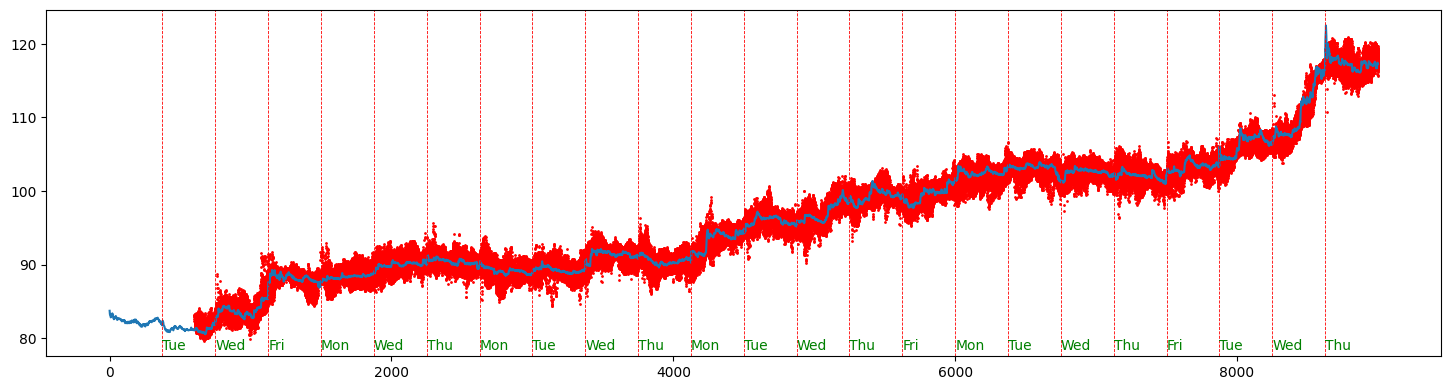

In [ ]:
scatter = Scatter(args, setting, sorted_weights[-1], mode='train')
scatter.plot(segment=[0, 9000]) ; plt.show()

## Visualize pertervations

In [ ]:
from models.nlinear_attention import Model
class Config:
    def __init__(self):
        self.seq_len = 120
        self.pred_len = 30
        self.enc_in = 13
        self.individual = False
        self.decomp_kernal = 25
model = Model(Config())

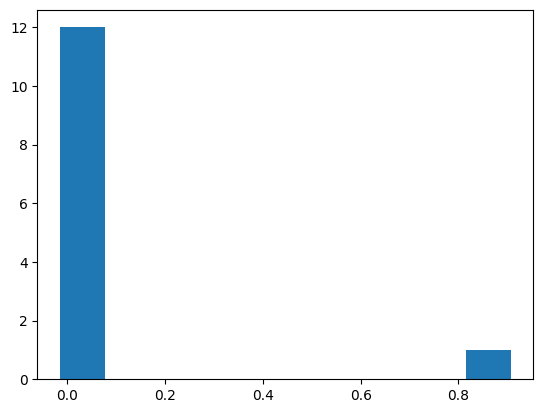

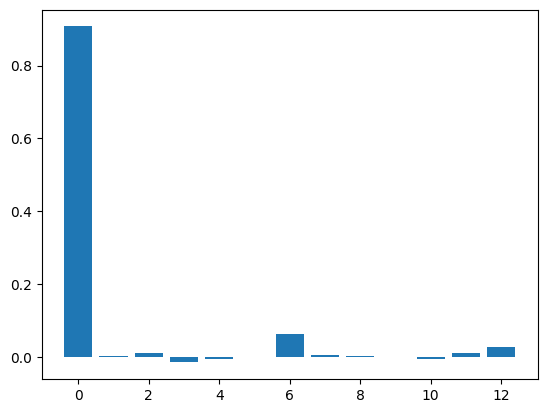

In [ ]:
model.load_state_dict(torch.load("{}/{}/{}".format(args.checkpoints, setting, sorted_weights[-1])))
attn_weights = model.Attention.weight.cpu().detach().numpy()
plt.hist(attn_weights[0]) ; plt.show()
plt.bar(np.arange(13), attn_weights[0]) ; plt.show()

In [ ]:
stocks = [i for i in range(len(attn_weights[0])) if abs(attn_weights[0][i])>0.1]
len(stocks)

1

In [ ]:
args = {
   'root_path': ltsf,
   'checkpoints': '{}/checkpoints/'.format(data_dir),
   'data_path': '03_23.csv',
   'seq_len': 120,
   'pred_len': 30,
   'batch_size': 16,
   'learning_rate': 0.05,
   'train_only': False,
   'train_epochs': 20,
   'data_segment': None,
   'model': 'nlinear_attention',
   'enc_in': 1,
   'patience': 5,
   'target': 0,
   'stocks': stocks
}

for key, value in args.items():
    default_args[key] = value
args = argparse.Namespace(**default_args)
    

for i in range(args.enc_in):
    print("\n-------------Training for target {}-------------\n".format(i))
    args.target = i
    exp = ExpMain(args)
    setting = 'mod_{}_sl{}_pl{}_ds_{}_tg_{}_ch_{}'.format(args.model, args.seq_len, args.pred_len, args.data_path.split('.')[0], args.target, args.enc_in)
    exp.train(setting)
    break


-------------Training for target 0-------------

Use CPU
Total number of parameters is: 3632
Original data shape: (14250, 2)
Data shape after inter-day:  8550
train 5836
Original data shape: (14250, 2)
Data shape after inter-day:  8550
val 826


100%|██████████| 364/364 [00:57<00:00,  6.31it/s]


Epoch: 1 | time: 57.67318892478943


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 1, Steps: 364 | Train Loss: 0.0347821 Vali Loss: 0.0047735
Validation loss decreased (inf --> 0.004774).  Saving model ...
Updating learning rate to 0.05


100%|██████████| 364/364 [00:57<00:00,  6.29it/s]


Epoch: 2 | time: 57.90030908584595


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 2, Steps: 364 | Train Loss: 0.0294847 Vali Loss: 0.0047110
Validation loss decreased (0.004774 --> 0.004711).  Saving model ...
Updating learning rate to 0.025


100%|██████████| 364/364 [00:57<00:00,  6.29it/s]


Epoch: 3 | time: 57.84532403945923


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 3, Steps: 364 | Train Loss: 0.0027385 Vali Loss: 0.0052191
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0125


100%|██████████| 364/364 [00:58<00:00,  6.27it/s]


Epoch: 4 | time: 58.01616621017456


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


Epoch: 4, Steps: 364 | Train Loss: 0.0022514 Vali Loss: 0.0028937
Validation loss decreased (0.004711 --> 0.002894).  Saving model ...
Updating learning rate to 0.00625


100%|██████████| 364/364 [00:57<00:00,  6.29it/s]


Epoch: 5 | time: 57.83249092102051


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


Epoch: 5, Steps: 364 | Train Loss: 0.0020627 Vali Loss: 0.0030524
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.003125


  0%|          | 1/364 [00:07<45:29,  7.52s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10945eb80>
Traceback (most recent call last):
  File "/Users/shiva/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/shiva/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/m

KeyboardInterrupt: 

In [ ]:
args = {
   'root_path': ltsf,
   'checkpoints': '{}/checkpoints/'.format(data_dir),
   'data_path': '03_23.csv',
   'seq_len': 120,
   'pred_len': 30,
   'batch_size': 1,
   'learning_rate': 0.025,
   'train_only': False,
   'train_epochs': 20,
   'data_segment': None,
   'model': 'nlinear_attention',
   'enc_in': 270,
   'patience': 5,
   'target': 0,
   'stocks': None
}

for key, value in args.items():
    default_args[key] = value

args = argparse.Namespace(**default_args)
setting = 'mod_{}_sl{}_pl{}_ds_{}_tg_{}_ch_{}'.format(args.model, args.seq_len, args.pred_len, args.data_path.split('.')[0], args.target, args.enc_in)

weights = os.listdir("{}/{}".format(args.checkpoints, setting))
sorted_weights = sorted(weights, key=lambda x: float(x.replace('checkpoint_','').replace('.pth','')), reverse=True)
sorted_weights